In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import datetime
import sys
from tqdm import tqdm
import os
import random
import pickle
from glob import glob
import gc
from multiprocessing import Pool, cpu_count

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle')
from utils.xgb import fit_xgb, inference_xgb
from utils.metric import compute_comptetition_metric
from utils.feature_contena import Features
from utils.pandas_utils import reduce_mem_usage

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
config = f"""
execution:
    exp_id: exp_040
    debug: False
    submit: False
    multiprocessing: True

dataset: 
    competition_dir: /kaggle/input/child-mind-institute-detect-sleep-states
    cv_split_path: /kaggle/input/cv_split/train_folds.csv
    train_base_path: /kaggle/input/train_base/train_base.csv
    step_csv_dir: /kaggle/input/save_series_csv/csvs
    oof_exp: exp_036

feature:
    agg_freq: 24 # [step]

xgboost:    
    objective: "reg:squarederror"
    learning_rate: 0.01  # 0.01で固定。学習時間とのトレードオフ
    reg_alpha: 0.02  # L1正則化。0.1が推奨。
    reg_lambda: 0.2  # L2正則化。0.1が推奨
    random_state: 42
    max_depth: 7  # 3-8。7くらいでいい。
    colsample_bytree: 0.5  # カラムが多い時は少なめ(0.4とか)にする。
    tree_method: "gpu_hist"
    
seed: 46
"""

CFG = yaml.load(config, Loader=yaml.SafeLoader)

CFG["output_dir"] = f"/kaggle/output/{CFG['execution']['exp_id']}"
os.makedirs(CFG["output_dir"], exist_ok=True)

In [3]:
sub = pd.read_csv(f'/kaggle/output/{CFG["dataset"]["oof_exp"]}/submission.csv')
oof = pd.read_csv(f'/kaggle/output/{CFG["dataset"]["oof_exp"]}/oof.csv')
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
display(sub.head())
display(oof.head())
display(labels.head())

,series_id,raw_step,event,score,step
0,038441c925bb,10931.5,wakeup,0.812971,10919
1,038441c925bb,23987.5,wakeup,-0.095061,23975
2,038441c925bb,27467.5,wakeup,0.883293,27455
3,038441c925bb,43979.5,wakeup,0.422262,43967
4,038441c925bb,61091.5,wakeup,0.647474,61079


,target,step,series_id,fold,oof_stage1,STAGE_stage1,raw_oof,oof_stage2,STAGE_stage2,minutes,oof
0,1,11.5,038441c925bb,2,NaN,2,0.999819,NaN,NaN,NaN,NaN
1,1,35.5,038441c925bb,2,NaN,2,0.999644,NaN,NaN,NaN,NaN
2,1,59.5,038441c925bb,2,NaN,2,0.993865,NaN,NaN,NaN,NaN
3,1,83.5,038441c925bb,2,NaN,2,0.995005,NaN,NaN,NaN,NaN
4,1,107.5,038441c925bb,2,NaN,2,0.994551,NaN,NaN,NaN,NaN


,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


## 周辺に予測を撒く

In [4]:
dfs = []
for level, diff in enumerate([0, -5, 5, -15, 15, -30, 30]):
    tmp = sub.copy()
    tmp["level"] = level
    tmp["step"] += CFG["feature"]["agg_freq"] * diff
    tmp["raw_step"] += CFG["feature"]["agg_freq"] * diff
    dfs.append(tmp)
sub = pd.concat(dfs, axis=0).reset_index(drop=True)
sub.sort_values(["series_id", "step", "level"], inplace=True)
sub = sub.drop_duplicates(["series_id", "step"], keep="first").reset_index(drop=True)
sub

,series_id,raw_step,event,score,step,level
0,038441c925bb,4307.5,onset,0.868351,4295,5
1,038441c925bb,4667.5,onset,0.868351,4655,3
2,038441c925bb,4907.5,onset,0.868351,4895,1
3,038441c925bb,5027.5,onset,0.868351,5015,0
4,038441c925bb,5147.5,onset,0.868351,5135,2
...,...,...,...,...,...,...
74671,fe90110788d2,581579.5,wakeup,0.800698,581567,1
74672,fe90110788d2,581699.5,wakeup,0.800698,581687,0
74673,fe90110788d2,581819.5,wakeup,0.800698,581807,2
74674,fe90110788d2,582059.5,wakeup,0.800698,582047,4


## 正解ラベルを作成

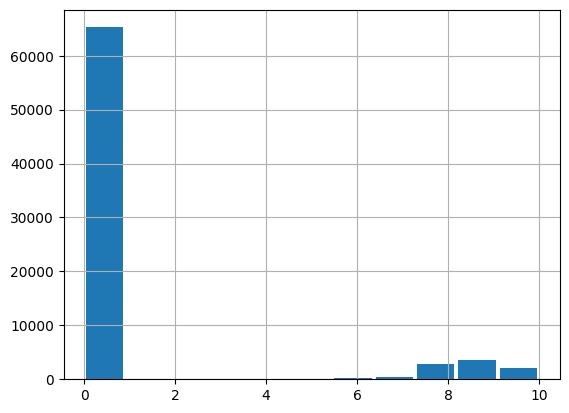

series_id    5331163
step         5331163
fold         5331163
raw_oof      5331163
minutes       692642
target         74582
sub_step       74582
raw_step       74582
event          74582
level          74582
score          74582
dtype: int64

In [5]:
thresholds = [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]
dfs = []
for (series_id, event), label_df in labels.groupby(["series_id", "event"]):
    sub_df = sub[(sub["series_id"] == series_id) & (sub["event"] == event)].reset_index(drop=True)
    targets = np.zeros(len(sub_df))
    for thresh in thresholds:
        matched = np.zeros(len(sub_df), dtype=bool)
        for step in label_df["step"].values:
            min_dist = thresh
            min_idx = -1            
            for idx, sub_step in enumerate(sub_df["step"].values):
                if matched[idx]:
                    continue
                dist = abs(step - sub_step)
                if dist < min_dist:
                    min_dist = dist
                    min_idx = idx
            if min_idx != -1:
                targets[min_idx] += 1
                matched[min_idx] = True
    sub_df["target"] = targets
    sub_df["sub_step"] = sub_df["step"].values
    dfs.append(sub_df)
sub = pd.concat(dfs).reset_index(drop=True)
plt.hist(sub["target"].values, bins=11, rwidth=0.9)
plt.grid()
plt.show()

oof = oof[["series_id", "step", "fold", "raw_oof", "minutes"]].merge(
    sub[["target", "series_id", "sub_step", "raw_step", "event", "level", "score"]], 
    left_on=["series_id", "step"], 
    right_on=["series_id", "raw_step"], 
    how="left",
    )
(~oof.isna()).sum()

In [6]:
(oof.target ** 2).mean() ** 0.5

3.087746289334821

In [7]:
oof.head()

,series_id,step,fold,raw_oof,minutes,target,sub_step,raw_step,event,level,score
0,038441c925bb,11.5,2,0.999819,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,038441c925bb,35.5,2,0.999644,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,038441c925bb,59.5,2,0.993865,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,038441c925bb,83.5,2,0.995005,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,038441c925bb,107.5,2,0.994551,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 特徴生成

In [8]:
def generate_features(train: pd.DataFrame):
    features = Features()
    features.add_num_features(["level", "score"])

    # 時刻
    train["total_seconds"] = train.index * 5 *  CFG["feature"]["agg_freq"] % (24 * 60 * 60)
    features.add_num_feature("total_seconds")    

    # 分
    features.add_num_feature("minutes")

    # gap
    train["gap"] = train["sub_step"] - train["step"]
    train["sub_minutes"] = (train["minutes"] + train["gap"] * 12) % (60 * 60)
    features.add_num_features(["gap", "sub_minutes"])

    columns = ["raw_oof"]

    # その人のその時刻での平均的な測定値
    gb = train.groupby("total_seconds")[columns].mean()
    gb.columns = [f"{c}_mean" for c in columns]
    train["raw_oof_mean"] = train["total_seconds"].map(gb["raw_oof_mean"])
    features.add_num_features(gb.columns.tolist())

    # diff
    f_names = [f"{c}_diff_abs" for c in columns]
    train[f_names] = train[columns].diff().abs()
    features.add_num_features(f_names)

    # 予測対象か
    train["for_pred"] = train["target"].notna().astype(float)

    columns += f_names
    columns += gb.columns.tolist()
    columns += ["for_pred"]

    # rolling
    dts = [1, 2, 3, 5, 10, 50]
    shift_features_dic = {}
    for dt in dts:       
        shift_features = []

        f_names = [f"{c}_rolling_mean_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).mean()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_std_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).std()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_max_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).max()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_min_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).min()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_median_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).median()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_square_mean_{dt}" for c in columns]
        train[f_names] = ((train[columns] ** 2).rolling(dt, center=True).mean())
        features.add_num_features(f_names)
        shift_features += f_names

        shift_features_dic[dt] = shift_features

    # shift
    for dt, shift_features in shift_features_dic.items():
        for c in [0.5, 1, 2]:
            _dt = int(dt * c)
            if _dt == 0:
                continue
            f_names_plus = [f"{c}_shift_{_dt}" for c in shift_features]
            train[f_names_plus] = train[shift_features].shift(_dt)
            features.add_num_features(f_names_plus)

            f_names_minus = [f"{c}_shift_{-_dt}" for c in shift_features]
            train[f_names_minus] = train[shift_features].shift(-_dt)
            features.add_num_features(f_names_minus)

            f_names_diff = [f"{c}_shift_{_dt}_diff" for c in shift_features]
            train[f_names_diff] = train[f_names_plus].values - train[f_names_minus].values
            features.add_num_features(f_names_diff)

    train = train.dropna(subset=["target"]).reset_index(drop=True)

    train = reduce_mem_usage(train)
    gc.collect()
    return train, features

def generate_features_for_group(group):
    _, df = group
    df, features = generate_features(df)
    return df, features

In [9]:
groups = list(oof.groupby("series_id"))

with Pool(30) as pool:
    results = list(tqdm(pool.imap(generate_features_for_group, groups), total=len(groups)))

dfs, features_list = zip(*results)
features = features_list[0]

100%|██████████| 277/277 [03:19<00:00,  1.39it/s]


In [10]:
train = pd.concat(dfs).reset_index(drop=True)
display(train.head())
print(train.shape)

,series_id,step,fold,raw_oof,minutes,target,sub_step,raw_step,event,level,...,raw_oof_mean_rolling_min_50_shift_100_diff,for_pred_rolling_min_50_shift_100_diff,raw_oof_rolling_median_50_shift_100_diff,raw_oof_diff_abs_rolling_median_50_shift_100_diff,raw_oof_mean_rolling_median_50_shift_100_diff,for_pred_rolling_median_50_shift_100_diff,raw_oof_rolling_square_mean_50_shift_100_diff,raw_oof_diff_abs_rolling_square_mean_50_shift_100_diff,raw_oof_mean_rolling_square_mean_50_shift_100_diff,for_pred_rolling_square_mean_50_shift_100_diff
0,038441c925bb,4307.5,2,0.999037,NaN,0.0,4295.0,4307.5,onset,5.0,...,0.742462,0.0,0.961868,-0.002942,0.719793,0.0,0.998202,-0.000029,0.916453,0.0
1,038441c925bb,4667.5,2,0.998153,NaN,0.0,4655.0,4667.5,onset,3.0,...,0.738575,0.0,0.963370,-0.003910,0.716151,0.0,0.998055,-0.000034,0.913349,0.0
2,038441c925bb,4907.5,2,0.961878,1137.5,0.0,4895.0,4907.5,onset,1.0,...,0.703715,0.0,0.958695,-0.003865,0.707156,0.0,0.997373,-0.000039,0.904342,0.0
3,038441c925bb,5027.5,2,0.152667,1737.5,9.0,5015.0,5027.5,onset,0.0,...,0.697197,0.0,0.951029,-0.004294,0.699380,0.0,0.996470,-0.000052,0.894567,0.0
4,038441c925bb,5147.5,2,0.074428,2337.5,0.0,5135.0,5147.5,onset,2.0,...,0.681425,0.0,0.943986,-0.004287,0.696763,0.0,0.995224,-0.000060,0.884408,0.0


(74582, 1385)


In [11]:
train["bin_event"] = train["event"].map({"onset": 0.0, "wakeup": 1.0})
features.add_num_feature("bin_event")

## 学習

In [12]:
# 学習
trn_oof, models = fit_xgb(
    X=train, 
    y=train["target"], 
    folds=train["fold"].astype(int), 
    features=features.all_features(),
    params=CFG["xgboost"], 
    es_rounds=50
)
train["oof"] = trn_oof

# 保存
for i, model in enumerate(models):
    model.save_model(os.path.join(CFG["output_dir"], f'xgb_fold{i}.model'))

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:2.97589
[50]	eval-rmse:2.33774
[100]	eval-rmse:2.04359
[150]	eval-rmse:1.91642
[200]	eval-rmse:1.86283
[250]	eval-rmse:1.83986
[300]	eval-rmse:1.82984
[350]	eval-rmse:1.82513
[400]	eval-rmse:1.82284
[450]	eval-rmse:1.82128
[500]	eval-rmse:1.82080
[550]	eval-rmse:1.81988
[600]	eval-rmse:1.81976
[639]	eval-rmse:1.81965


 20%|██        | 1/5 [00:13<00:53, 13.28s/it]

== fold 1 ==
[0]	eval-rmse:2.95812
[50]	eval-rmse:2.37327
[100]	eval-rmse:2.10259
[150]	eval-rmse:1.98392
[200]	eval-rmse:1.93376
[250]	eval-rmse:1.91128
[300]	eval-rmse:1.90171
[350]	eval-rmse:1.89665
[400]	eval-rmse:1.89389
[450]	eval-rmse:1.89256
[500]	eval-rmse:1.89102
[550]	eval-rmse:1.89003
[600]	eval-rmse:1.88959
[650]	eval-rmse:1.88928
[700]	eval-rmse:1.88882
[750]	eval-rmse:1.88841
[800]	eval-rmse:1.88841
[817]	eval-rmse:1.88837


 40%|████      | 2/5 [00:28<00:43, 14.50s/it]

== fold 2 ==
[0]	eval-rmse:2.94517
[50]	eval-rmse:2.36417
[100]	eval-rmse:2.10790
[150]	eval-rmse:2.00480
[200]	eval-rmse:1.96256
[250]	eval-rmse:1.94694
[300]	eval-rmse:1.94005
[350]	eval-rmse:1.93600
[400]	eval-rmse:1.93468
[450]	eval-rmse:1.93367
[500]	eval-rmse:1.93274
[550]	eval-rmse:1.93212
[600]	eval-rmse:1.93134
[650]	eval-rmse:1.93086
[689]	eval-rmse:1.93117


 60%|██████    | 3/5 [00:41<00:27, 13.84s/it]

== fold 3 ==
[0]	eval-rmse:2.85538
[50]	eval-rmse:2.28925
[100]	eval-rmse:2.03839
[150]	eval-rmse:1.93634
[200]	eval-rmse:1.89744
[250]	eval-rmse:1.88253
[300]	eval-rmse:1.87812
[350]	eval-rmse:1.87629
[400]	eval-rmse:1.87569
[447]	eval-rmse:1.87642


 80%|████████  | 4/5 [00:50<00:11, 11.97s/it]

== fold 4 ==
[0]	eval-rmse:2.93474
[50]	eval-rmse:2.35101
[100]	eval-rmse:2.09415
[150]	eval-rmse:1.99242
[200]	eval-rmse:1.95306
[250]	eval-rmse:1.93879
[300]	eval-rmse:1.93370
[350]	eval-rmse:1.93196
[400]	eval-rmse:1.93192
[423]	eval-rmse:1.93185


100%|██████████| 5/5 [00:59<00:00, 11.87s/it]


In [13]:
train["score"] = train["oof"]
train["raw_step"] = train["step"]
train["step"] = train["sub_step"].astype(int)
sub = train[["score", "raw_step", "step", "event", "level", "series_id"]]
sub.to_csv(os.path.join(CFG["output_dir"], "submission.csv"), index=False)

In [14]:
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)
print(f"score: {score:.4f}")
display(ap_table)

score: 0.7052


event   tolerance
onset   12           0.061857
        36           0.405697
        60           0.699294
        90           0.761375
        120          0.798732
        150          0.816866
        180          0.828143
        240          0.840541
        300          0.849365
        360          0.857052
wakeup  12           0.105194
        36           0.462809
        60           0.716048
        90           0.783152
        120          0.814857
        150          0.829919
        180          0.844719
        240          0.862116
        300          0.878613
        360          0.887654
dtype: float64

In [15]:
sub

,score,raw_step,step,event,level,series_id
0,0.028691,4307.5,4295,onset,5.0,038441c925bb
1,0.019222,4667.5,4655,onset,3.0,038441c925bb
2,0.271996,4907.5,4895,onset,1.0,038441c925bb
3,7.758776,5027.5,5015,onset,0.0,038441c925bb
4,0.146485,5147.5,5135,onset,2.0,038441c925bb
...,...,...,...,...,...,...
74577,4.819500,581579.5,581567,wakeup,1.0,fe90110788d2
74578,2.410315,581699.5,581687,wakeup,0.0,fe90110788d2
74579,2.542801,581819.5,581807,wakeup,2.0,fe90110788d2
74580,0.086812,582059.5,582047,wakeup,4.0,fe90110788d2
